# Kernel Learning - SVM

1. 최적화 문제 정의

2. 라그랑주 승수법을 통해서 라그랑주 목적 함수로 변환 

3. 목적 함수를 듀얼 함수로 변경하여 $\alpha_i$ 의 해 찾기 

4. 커널 트릭을 도입한다. 

---- 

**실제 계산 과정**
1. 듀얼 문제의 풀이를 통해 $\alpha_i$ 해 찾기 

2. $\alpha_i$를 통해 W, b의 값 찾기 

3. 직선 분류기 반환 및 새로운 값을 분류할 함수 제작 

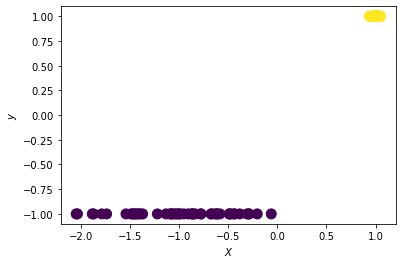

In [7]:
# 데이터 사용 및 라이브러리 설치 
! pip install cvxopt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification 

# 시각화를 위해서 n_feature을 1개만 설정. 실제 데이터로는 독립 변수가 10개 이상으로 설정할 예정. 
X, y = make_classification(n_features = 1, n_informative = 1, n_redundant = 0, n_classes = 2, n_clusters_per_class = 1)
y = [2*x -1 for x in y] # y 값의 분류를 1 / -1 로 재설정 

plt.scatter(X,y, marker = 'o', c=y, s = 100)
plt.xlabel("$X$")
plt.ylabel("$y$")
plt.show()


In [46]:
X, y = make_classification(n_features = 10, n_informative = 5, n_redundant = 3, n_classes = 2, n_clusters_per_class = 1)
y = [2*x -1 for x in y] # y 값의 분류를 1 / -1 로 재설정 

In [55]:
from IPython.display import Image

### 1. 듀얼 문제의 풀이를 통해  𝛼𝑖  해 찾기 - 1차 실패 

**구현해야하는 것** 
- 듀얼 문제 해답찾는 방법 : 아래에 기술 

**필요한 것**
- X : 입력 데이터 
- y : 분류 결과  
- c : 비용함수 

**함수의 형태**
- def __init__(self, X,y,c) 

- def a_matrix(self, X,y) : => a matrix 반환 

- def find_alpha(self) : => alpha 값 반환

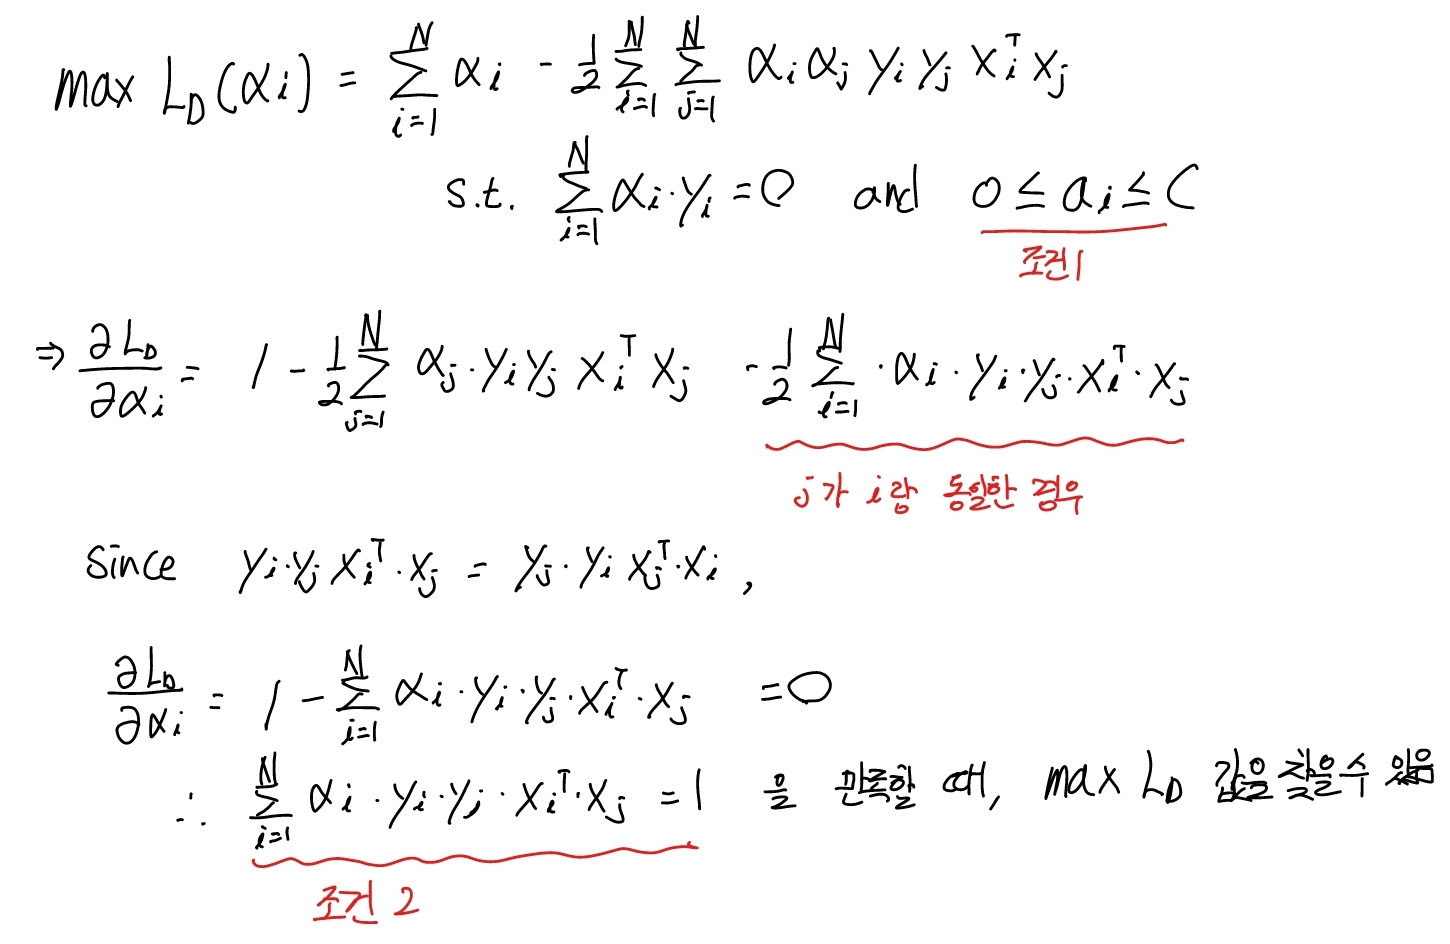

In [61]:
Image("picture/svr-1.jpg")

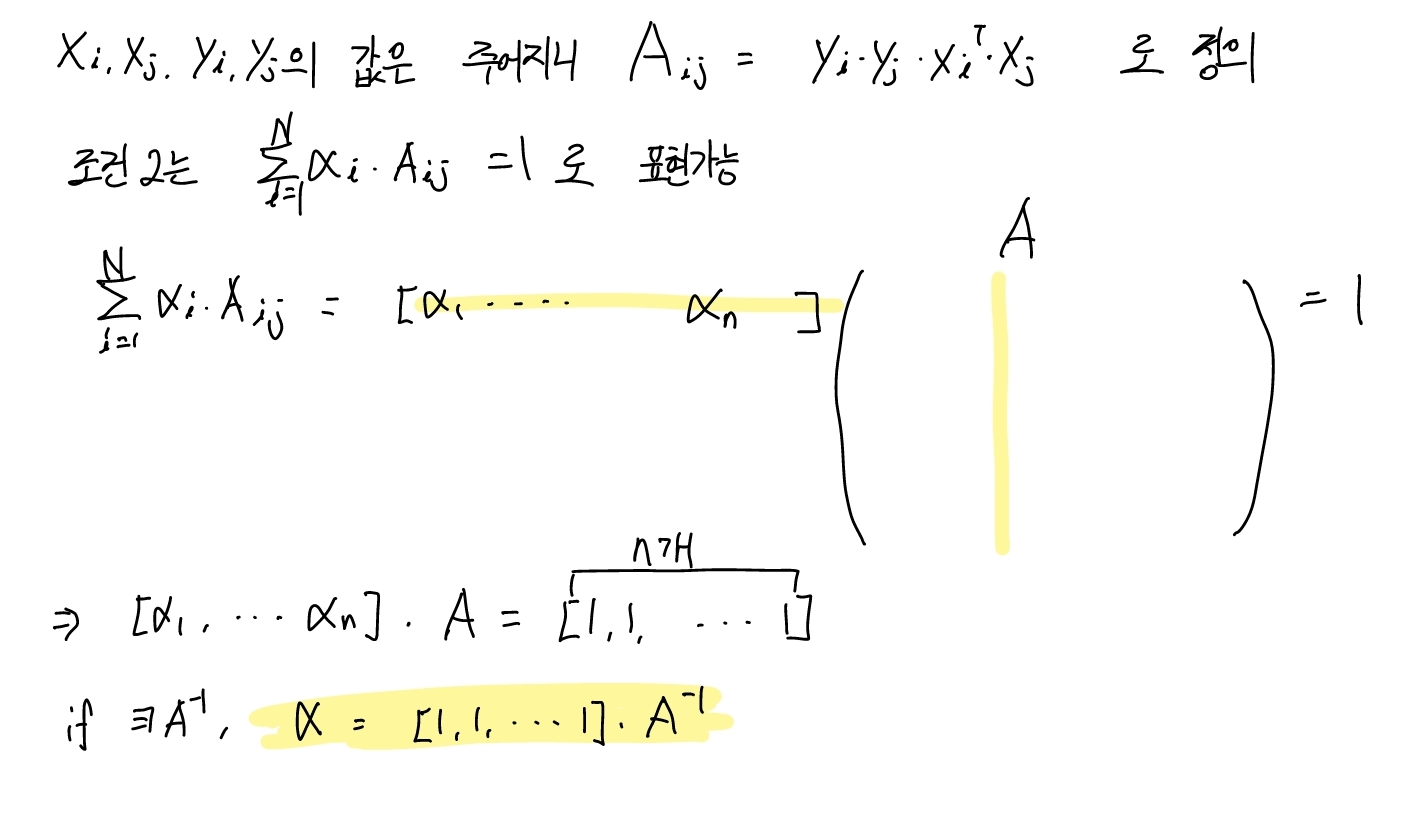

In [62]:
Image("picture/svr-2.jpg")

In [68]:
class SVM() :
    def __init__(self,X,y,c) :
        self.X = X
        self.y = y 
        self.n = np.shape(X)[0]
        self.c =c 
        
    def a_matrix(self,X,y) : 
        a_matrix = []
        for i in range(self.n) : 
            vector = [y[i]*y[j]*np.dot(X[i], X[j]) for j in range(self.n)]
            a_matrix.append(vector)
        return np.array(a_matrix) 
    
    def check_inv(self) : # 역행렬이 존재하기란 쉽지 않다... 
        a_matrix = self.a_matrix(self.X, self.y) 
        if np.linalg.det(a_matrix) == 0 : 
            return print("no inverse")
        else : 
            return print("inverse is exist")


In [69]:
test = SVM(X,y, 3) 
test.check_inv()

no inverse


### 1. 듀얼 문제의 풀이를 통해  𝛼𝑖  해 찾기 
#### 참고 - https://ms930.github.io/

**구현해야하는 것** 
- 듀얼 문제 해답찾는 방법 : cvsopt 라이브러리 이용 
- cvsotp : $min \frac{1}{2}x^TPx - q^Tx$ s.t. $Gx >= h$ and $Ax = b$ 식에 대한 x 해를 찾아줌 
- $max L_D = min (- L_D)$

> $-L_D$ : $\sum_{i=1}^n \alpha_i - \frac{1}{2}\sum_{i=1}^m \sum_{j=1}^n \alpha_i \alpha_j y_i y_j \phi(x_i)^T\phi(x_j)$ 

> = min $\frac{1}{2}\alpha^TA\alpha - 1^T\alpha$ s.t. $ C >= \alpha_i >= 0$ and $y^T\alpha =0$ 



**필요한 것**
- X : 입력 데이터 
- y : 분류 결과  
- c : 비용함수 

**함수의 형태**
- def __init__(self, X,y,c) 

- def find_alpha(self) : => alpha 값 반환

In [55]:
# 오류 발생. 단 A.size[1] == q.size[0] 인 상태인데도 계속 오류 발생. 
"""
~\anaconda3\lib\site-packages\cvxopt\coneprog.py in coneqp(P, q, G, h, dims, A, b, initvals, kktsolver, xnewcopy, xdot, xaxpy, xscal, ynewcopy, ydot, yaxpy, yscal, **kwargs)
   1911     if matrixA:
   1912         if A.typecode != 'd' or A.size[1] != q.size[0]:
-> 1913             raise TypeError("'A' must be a 'd' matrix with %d columns" \
   1914                 %q.size[0])
   1915         def fA(x, y, trans = 'N', alpha = 1.0, beta = 0.0):

TypeError: 'A' must be a 'd' matrix with 100 columns

"""

import cvxopt
import cvxopt.solvers

class SVM() :
    def __init__(self,X,y,C) :
        self.X = X
        self.y = y 
        self.n = np.shape(X)[0]
        self.C =C
        
    def find_alpha(self) :
        """
        P = A. xi^T xj yi yj
        q = 1. (n x 1) 배열 
        A = np.diag(y)
        b = np.zeros(self.n)
        G = I / cost 함수가 있을 경우 I + -I
        h = 0 / cost 함수가 있을 경우 -c 값
        
        """
        
        a_matrix = []
        for i in range(self.n) : 
            vector = [np.dot(self.X[i], self.X[j])*self.y[i]*self.y[j] for j in range(self.n)] 
            a_matrix.append(vector)
        P = cvxopt.matrix(a_matrix)
        q = cvxopt.matrix(np.ones(self.n)* -1)
        print(q.size[0])
        A = cvxopt.matrix(np.array(self.y).reshape(1,-1))
        print(A.size[1])
        print(A.typecode)
        
        b = cvxopt.matrix(np.zeros(1))
        
        if self.C is None : 
            G = cvxopt.matrix(np.identity(self.n))
            h = cvxopt.matrix(np.zeros(self.n))
        
        else : 
            tmp1 = np.identity(self.n)
            tmp2 = np.identity(self.n)
            G = cvxopt.matrix(np.vstack((tmp1, tmp2))) 
            
            tmp1 = np.zeros(self.n)
            tmp2 = np.ones(self.n)* (-self.C)
            h = cvxopt.matrix(np.hstack((tmp1, tmp2)))
        
        solution = cvxopt.solvers.qp(P,q,G,h,A,b) 
        alphas = np.ravel(solution['x'])
        return alphas
    



In [58]:
test = SVM(X,y,4)
test.find_alpha()

100
100
i


TypeError: 'A' must be a 'd' matrix with 100 columns

### 2. $\alpha_i$를 통해 W, b의 값 찾기 

### 3. 직선 분류기 반환 및 새로운 값을 분류할 함수 제작 

**구현해야하는 것** 
- W : $\sum_{i=1}^N \alpha_iy_ix_i$ 
- b : $y_i - w^Tx_i$

**필요한 것**
- \alpha_i 
- x_i  
- y_i 

**함수의 형태**
- def parameter(self) : w,b 값 반환  

In [ ]:
import cvxopt
import cvxopt.solvers

class SVM() :
    def __init__(self,X,y,C) :
        self.X = X
        self.y = y 
        self.n = np.shape(X)[0]
        self.C =C
        
    def find_alpha(self) :
        """
        P = A. xi^T xj yi yj
        q = 1. (n x 1) 배열 
        A = np.diag(y)
        b = np.zeros(self.n)
        G = I / cost 함수가 있을 경우 I + -I
        h = 0 / cost 함수가 있을 경우 -c 값
        
        """
        
        a_matrix = []
        for i in range(self.n) : 
            vector = [np.dot(self.X[i], self.X[j])*self.y[i]*self.y[j] for j in range(self.n)] 
            a_matrix.append(vector)
        P = cvxopt.matrix(a_matrix)
        q = cvxopt.matrix(np.ones(self.n)* -1)
        print(q.size[0])
        A = cvxopt.matrix(np.array(self.y).reshape(1,-1))
        print(A.size[1])
        print(A.typecode)
        
        b = cvxopt.matrix(np.zeros(1))
        
        if self.C is None : 
            G = cvxopt.matrix(np.identity(self.n))
            h = cvxopt.matrix(np.zeros(self.n))
        
        else : 
            tmp1 = np.identity(self.n)
            tmp2 = np.identity(self.n)
            G = cvxopt.matrix(np.vstack((tmp1, tmp2))) 
            
            tmp1 = np.zeros(self.n)
            tmp2 = np.ones(self.n)* (-self.C)
            h = cvxopt.matrix(np.hstack((tmp1, tmp2)))
        
        solution = cvxopt.solvers.qp(P,q,G,h,A,b) 
        alphas = np.ravel(solution['x'])
        return alphas
    
    def parameter(self) : 
        alphas = self.find_alpha()
        W = [alphas[i]*self.y[i]*self.X[i] for i in range(self.n)] 
        b = [self.y[i] - np.dot(W[i], self.X[i]) for i in range(self.n)]
        return W,b
        



In [ ]:
# 커널 도입 

import cvxopt
import cvxopt.solvers

class SVM() :
    def __init__(self,X,y,C, K) :
        self.X = X
        self.y = y 
        self.n = np.shape(X)[0]
        self.C =C
        self.K = K 
        self.K_matrix = np.zeros(self.n, self.n)
        self.K_matrix = self.kernel()
        
        
    def find_alpha(self) :
        """
        P = A. xi^T xj yi yj
        q = 1. (n x 1) 배열 
        A = np.diag(y)
        b = np.zeros(self.n)
        G = I / cost 함수가 있을 경우 I + -I
        h = 0 / cost 함수가 있을 경우 -c 값
        
        """
        

        P = cvxopt.matrix(np.outer(self.y,self.y)*self.K_matrix )
        q = cvxopt.matrix(np.ones(self.n)* -1)
        print(q.size[0])
        A = cvxopt.matrix(np.array(self.y).reshape(1,-1))
        print(A.size[1])
        print(A.typecode)
        
        b = cvxopt.matrix(np.zeros(1))
        
        if self.C is None : 
            G = cvxopt.matrix(np.identity(self.n))
            h = cvxopt.matrix(np.zeros(self.n))
        
        else : 
            tmp1 = np.identity(self.n)
            tmp2 = np.identity(self.n)
            G = cvxopt.matrix(np.vstack((tmp1, tmp2))) 
            
            tmp1 = np.zeros(self.n)
            tmp2 = np.ones(self.n)* (-self.C)
            h = cvxopt.matrix(np.hstack((tmp1, tmp2)))
        
        solution = cvxopt.solvers.qp(P,q,G,h,A,b) 
        alphas = np.ravel(solution['x'])
        return alphas
    
    def kernel(self) : 
        for i in range(len(self.n)) : 
            for j in range(len(self.n)) : 
                self.K_matrix[i,j] = self.K(self.X[i], self.X[j])
        return self.K_matrix
    
    def parameter(self, K) : 
        alphas = self.find_alpha()
        W = [alphas[i]*self.y[i]*self.K_matrix[i] for i in range(self.n)] 
        b = [self.y[i] - np.dot(W[i], self.K_matrix[i]) for i in range(self.n)]
        return W,b
        

